In [67]:
import cv2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

img = cv2.imread("imori.jpg")
img_gamma = cv2.imread("imori_gamma.jpg")
img_dark = cv2.imread("imori_dark.jpg")
img = img[:,:,[2,1,0]]
img_gamma = img_gamma[:,:,[2,1,0]]
img_dark = img_dark[:,:,[2,1,0]]

## 直方图归一化(Histogram Normalization)
又称灰度变换，主要适用于将灰度图片还原到彩色图片

公式如下：
$$
x_{out}=\begin{cases}a& (\text{if}\quad x_{in}<c)\\\frac{b-a}{d-c}\ (x_{in}-c)+a&(\text{else if}\quad c\leq x_{in}<d)\\b&(\text{else})\end{cases}
$$



In [40]:
def normalHist(img):
    a = 0
    b = 255
    c = img.min()
    d = img.max()
    img = (b-a)/(d-c)*(img-c)+a
    img = img .astype(np.uint8)
    return img

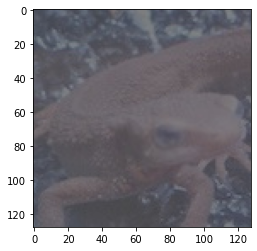

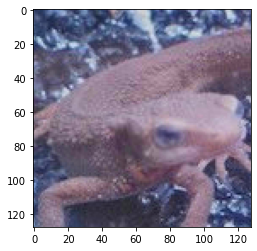

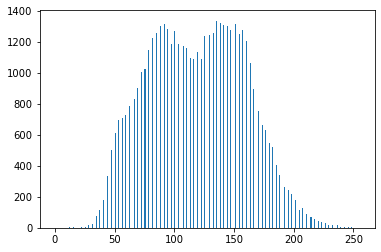

In [41]:
plt.imshow(img_dark)
plt.show()

img1 = img_dark.copy()
img1 = normalHist(img1)
plt.imshow(img1)
plt.show()
hist1 = plt.hist(img1.reshape(-1),bins=255,rwidth=0.85,range=(0,255))

## 直方图平坦化(evenHist)
调整直方图的平均值和标准差
$$ x_{out}=\frac{s_0}{s}\ (x_{in}-m)+m_0 $$

In [42]:
def evenHist(img,m0,s0):
    m = img.mean()
    s = np.sqrt(img.var())
    img = (s0/s)*(img-m)+m0
    img = img.astype(np.uint8)
    return img

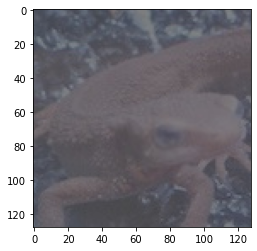

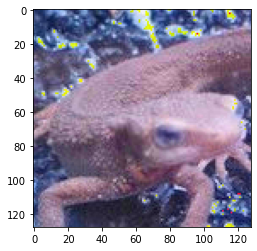

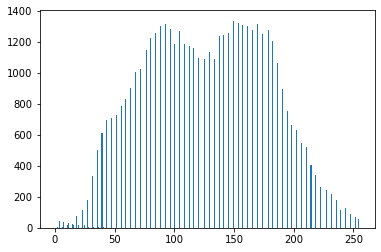

In [43]:
plt.imshow(img_dark)
plt.show()

img2 = img_dark.copy()
img2 = evenHist(img2,128,52)
plt.imshow(img2)
plt.show()
hist1 = plt.hist(img2.reshape(-1),bins=255,rwidth=0.85,range=(0,255))

## 直方图均衡化(Histogram Equalization)

直方图均衡化保证在图像像素映射过程中原来的大小关系保持不变，即较亮的区域依旧较亮，较暗的依旧较暗，只是对比度增加，不能明暗颠倒；保证像素映射函数的值域在0和255之间。

按照以下步骤对像素值进行处理：

1. 对图像中的像素点进行统计，统计每个像素值对应的个数和占比

2. 进行函数映射，zmax是映射范围，一般为255。h(i)的累加是灰度值的累计像素个数。S是像素点个数
$$ Z' = Z_{max} \ \frac{\sum\limits_{i=0}^z\ h(i)}{S} $$

计算方法就是用当前灰度值的累计像素个数乘上要分布映射的范围(255)

> 比如100个像素点，其中像素值最小为3，个数为5个，（sum(3) = 5）

> 那么就把像素值为3的像素点值改为   $255×(\frac{5}{100}) = 12.75$ ---> 取整   ---->   13

> 下一个像素值为4，个数有8个，那么sum(4) = 5+8 = 12

> 把像素值为4的像素点值改为   $255×(\frac{12}{100}) = 30.6$   ----> 取整 ---->   31

> 依次累加计算像素值

In [104]:
def equalHist(img):
    result = np.zeros_like(img)
    #像素总数
    imgsize = img.size
    #统计0~255的值的个数
    count = np.bincount(img.reshape(-1))
    
    for i in range(count.size):
        #如果这个像素值的个数不为0（就是存在该像素值的点）
        if count[i]:
            #计算累计个数
            sum = count[:i+1].sum()
            x = 255*(sum/imgsum)
            #四舍五入后转为uint8类型
            x = np.around(x).astype(np.uint8)
            #修改原本的像素值，改动放到新的图片上，以免打乱后面的像素值运算
            result[img == i] = x
    
    return result

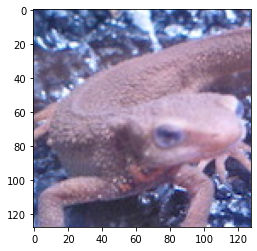

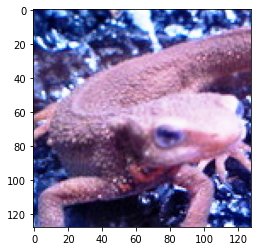

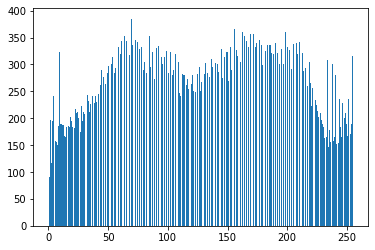

In [105]:
plt.imshow(img)
plt.show()

img3 = img.copy()
img3 = equalHist(img3)
plt.imshow(img3)
plt.show()
hist1 = plt.hist(img3.reshape(-1),bins=255,rwidth=0.85,range=(0,255))

## 伽马矫正(Gamma Correction)
伽马矫正用于调整图片的亮度。

由于照相机拍摄的图片在显示器上显示较暗。所以要进行伽马矫正。

矫正方法(c为常数，$\gamma$为伽马指数)：

$$归一化： x_{normal} = x_{in}/ 255 $$
$$伽马矫正： x_{gamma} = \frac{1}{c}·x_{normal}^{\frac{1}{\gamma}}$$
$$反归一化：x_{out} = x_{gamma}·255$$

假设图像中有一个像素，值是 200 ，那么对这个像素进行校正必须执行如下步骤： 
> 1. 归一化 ：将像素值转换为  0 ～ 1  之间的实数。 算法如下 : ( i + 0. 5)/256  这里包含 1 个除法和 1 个加法操作。对于像素  A  而言  , 其对应的归一化值为  0. 783203 。 


> 2. 预补偿 ：根据公式  , 求出像素归一化后的 数据以  1 /gamma  为指数的对应值。这一步包含一个 求指数运算。若  gamma  值为  2. 2 ,  则  1 /gamma  为  0. 454545 , 对归一化后的  A  值进行预补偿的结果就 是  0. 783203 ^0. 454545 = 0. 894872 。 


> 3. 反归一化 ：将经过预补偿的实数值反变换为  0  ～  255  之间的整数值。具体算法为 : f*256 - 0. 5  此步骤包含一个乘法和一个减法运算。续前 例  , 将  A  的预补偿结果  0. 894872  代入上式  , 得到  A  预补偿后对应的像素值为  228 , 这个  228  就是最后送 入显示器的数据。




In [139]:
def gammaCorrection(img,gamma,c = 1):
    img_normal = (img+0.01)/255
    img_gamma = (1/c)*np.power(img_normal,(1/gamma))
    img_out = img_gamma*255 - 0.01
    #防止溢出
    img_out = np.clip(img_out, 0, 255)
    result = img_out.astype(np.uint8)
    return result

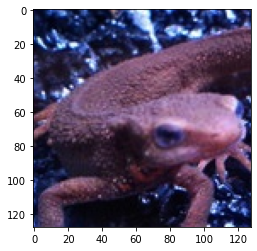

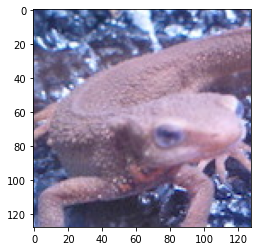

In [141]:
plt.imshow(img_gamma)
plt.show()

img4 = img.copy()
img4 = gammaCorrection(img4,1)
plt.imshow(img4)
plt.show()

参考输出的图片过暗，感觉gamma=1正好符合输出效果，而2.2则过亮

## 最邻近插值(Nearest-neighbor Interpolation)
将放大后的像素点位置设为近邻点的像素值，达到粗劣的放大效果,$\alpha$为放大比例
$$ I'(x,y) = I([\frac{x}{\alpha}], [\frac{y}{\alpha}]) $$ 

In [213]:
def nnInterpolation(img,a):
    newshape = [int(img.shape[0]*a),int(img.shape[1]*a),img.shape[2]]
    result = np.zeros((newshape))
    for x in range(newshape[0]):
        for y in range(newshape[1]):
            x_a = int(np.floor(x/a))
            y_a = int(np.floor(y/a))
            result[x,y] = img[x_a,y_a]
    
    result = result.astype(np.uint8)
    return result

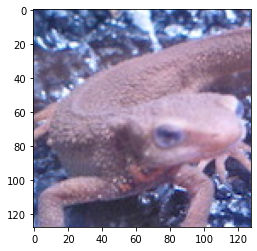

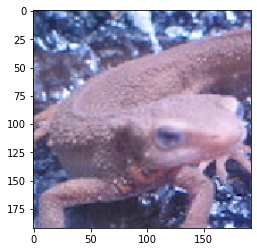

In [215]:
plt.imshow(img)
plt.show()

img5 = img.copy()
img5 = nnInterpolation(img5,1.5)
plt.imshow(img5)
plt.show()